AG News Dataset is a news classification which has four targets:
- {World, Sports, Business, Sci/Tech}

In this notebook, we will use `torchtext` library which is a library for handling text (aside from gensim, nltk, spacy etc.).

Note: time steps are nothing but words in a single sequence. We will batch of such sequences. A sequence is a set of words.

Learning Mechanism of RNN is Simple backpropagation through time (BPTT).

In [1]:
!which python

/usr/local/bin/python


In [2]:
!python --version

Python 3.11.12


In [158]:
# !pip3 install torch torchvision torchaudio torchtext torchdata --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install spacy

In [8]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
!pip install torchtext torchdata --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 126.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/20

In [1]:
!pip install "numpy<2"

In [2]:
!pip install portalocker>=2.0.0

In [3]:
import torch
torch.__version__

'2.2.0+cu118'

In [4]:
import numpy
numpy.__version__

'1.26.4'

In [5]:
import torchtext
torchtext.__version__

'0.17.0+cpu'

In [1]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchtext, torchvision


In [2]:
!pip list | grep torch

torch                                 2.6.0+cu124
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchsummary                          1.5.1
torchtext                             0.18.0
torchvision                           0.21.0+cu124


In [167]:
import torch, torchdata, torchtext
from torch import nn as nn

from torchtext.datasets import AG_NEWS

from torch.utils.data import DataLoader

import time

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# print(torch.cuda.get_device_name(0))

cpu


### 1. ETL: Extact, Transform and Load the Dataset

In [168]:
# Load the dataset
train, test = AG_NEWS()

In [169]:
type(train), type(test)

(torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe,
 torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe)

### 2. EDA - simple investigation

In [170]:
next(iter(train))  # (label, text)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [171]:
train_size = len(list(iter(train)))
test_size = len(list(iter(test)))
train_size, test_size

/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


(120000, 7600)

Since 120000 gonna just take up too much of our compute, we gonna resize it for now. All DataPipe instances has a handy function called random_split.

In [172]:
# List the labels
set([y for y, x in list(iter(train))])  # { World, Sports, Business, Sci/Tech}

{1, 2, 3, 4}

In [173]:
remaining_train, train, val = train.random_split(total_length=train_size, weights={"remaining_train": 0.7, "smaller_train": 0.2, "val": 0.1}, seed=SEED)

In [174]:
train_size = len(list(iter(train)))
val_size = len(list(iter(val)))
remaining_size = len(list(iter(remaining_train)))

train_size, val_size, remaining_size

(24000, 12000, 84000)

### 3. Preprocessing

#### Tokenization

We can do spacy en_core_web_sm model with gensim simple_preprocess or torch text tokenizer.

In [175]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

In [176]:
tokens = tokenizer("We are doing 'AG News' classification..hurray!")
tokens

['We',
 'are',
 'doing',
 "'",
 'AG',
 'News',
 "'",
 'classification',
 '..',
 'hurray',
 '!']

#### Text to integers (numeral)
Next we gonna call a built in factory function `build_vocab_from_iterator`  from `torchtext.vocab` that turn these tokens into integers. This function accepts iterator that yield list or iterator of tokens.

In [177]:
# Generate vocab and word2idx
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_pipe):
    for _, text in data_pipe:
        yield tokenizer(text)

word2idx = build_vocab_from_iterator(iterator=yield_tokens(train), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
word2idx.set_default_index(word2idx["<unk>"])

In [178]:
type(word2idx), len(word2idx)

(torchtext.vocab.vocab.Vocab, 52686)

In [179]:
word2idx["<unk>"], word2idx["<pad>"], word2idx["<bos>"], word2idx["<eos>"]

(0, 1, 2, 3)

In [180]:
word2idx(['here', 'is', 'a', 'unknownword', 'a'])

[532, 27, 9, 0, 9]

In [181]:
word2idx(['dddd', 'aaaa']) # unknown words are mapped to <unk> which has 0 as its index

[0, 0]

In [182]:
# Generate idx2word
idx2word = word2idx.get_itos()

In [183]:
idx2word[532]

'here'

### 4. Preparing DataLoader

We use collate function to perform some transformations on the batch before sending it to the dataloader

In [184]:
# Lets change the labels to start from index 0 rather than 1 by default

label_pipeline = lambda y: int(y) - 1  # turns existing labels {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training

In [185]:
text_pipeline = lambda x: word2idx(tokenizer(x))

In [186]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    labels, texts = [], []
    for (_y, _x) in batch:
        labels.append(label_pipeline(_y))
        processed_texts = torch.tensor(text_pipeline(_x), dtype=torch.int64)
        texts.append(processed_texts)
    return torch.tensor(labels, dtype=torch.int64), pad_sequence(texts, batch_first=True, padding_value=0)  # (bs, seqlen, ..) for batch_first=True, by default its (seqlen, bs, ..)

`pad_sequence` simply pad the variable length tensors in a batch to 0s to make sure every sequence in the batch has the same length, thus allowing the matrix multiplication to work in batches.

In [187]:
# Let's imagine two sentences in the same batch, but difference length
first_sentence  = [5, 6, 7]
second_sentence = [4, 99]

# convert to torch tensors
first_sentence  = torch.tensor(first_sentence,  dtype=torch.int64)
second_sentence = torch.tensor(second_sentence, dtype=torch.int64)

# append to a list
text_list = []
text_list.append(first_sentence)
text_list.append(second_sentence)

# now let's try pad_sequence
pad_sequence(text_list, batch_first=True) # as you can see it adds 0

tensor([[ 5,  6,  7],
        [ 4, 99,  0]])

In [188]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(dataset=val, batch_size=batch_size, collate_fn=collate_batch)
test_dataloader = DataLoader(dataset=test, batch_size=batch_size, collate_fn=collate_batch)

In [189]:
# Test the dataloader
for label, text in train_dataloader:
    break

label.shape, text.shape  # (bs,), (bs, seqlen)  here seqlen is the length of biggest seq in the batch => all sequences have the same length.

(torch.Size([64]), torch.Size([64, 88]))

Note that each batch has different sequence length.

In [190]:
for label, text in train_dataloader:
    break

label.shape, text.shape

(torch.Size([64]), torch.Size([64, 89]))

In [191]:
# Let's get only the label of the first sample
label[0]

tensor(3)

In [192]:
# sentence/sequence
text[0]

tensor([13570,  5287,  3831,  5160,   599,  1209, 28275,  1448,   599,  5160,
        44168,   355,    15,   427,    11,   520,  1605,  4267,     6,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])

In [193]:
# Let's try to look what is this about
word2idx.lookup_tokens(list(text[0]))

['Chipmaker',
 'Fujitsu',
 'prepares',
 'WiMax',
 'chip',
 'Company',
 'preps',
 'single',
 'chip',
 'WiMax',
 'compliant',
 'part',
 'for',
 'use',
 'in',
 'wireless',
 'broadband',
 'gear',
 '.',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

### 5. Model

Vanilla RNN Model
- Embedding Layer
- RNN Layer
- Linear fully connected layer

RNN takes in sequence of words $X = {x_1, x_2,....x_T}$, one at a time, and produces a hidden state $h$, for each word. We use the RNN recurrently by feeding in the current word $x_t$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_t$

\begin{equation}
h_t = \text{RNN}(x_t,\ h_{t-1})
\end{equation}

Once we have our final hidden state, $h_T$, (from feeding in the last word in the sequence, $x_T$) we feed it through a linear layer, $f$, (also known as a fully connected layer), to receive our predicted sentiment, $\hat{y} = f(h_T)$.

Below shows an example sentence, with the RNN predicting zero, which indicates a negative sentiment. The RNN is shown in orange and the linear layer shown in silver. Note that we use the same RNN for every word, i.e. it has the same parameters. The initial hidden state, $h_0$, is a tensor initialized to all zeros/some distribution.

This operations happens for each sequence in a batch.

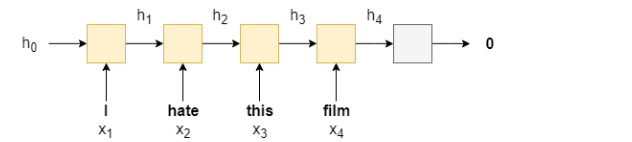

The embedding layer is used to transform our integer into a vector. Here we gonna create one vector sized 200 for one integer. Thus the embedding layer shall be nn.Embedding(len(vocab), 200)

The RNN returns 2 tensors
- output of size `[sentence length, batch size, hidden dim]` (Note: batch_first=false)
- hidden of size `[1, batch size, hidden dim]` = (num_layers * num_directions, bs, hidden_dim)

output is the concatenation of the hidden state from every time step, whereas hidden is simply the final hidden state. We verify this using the assert statement. Note the squeeze method, which is used to remove a dimension of size 1.

Finally, we feed the last hidden state `hidden`, through the linear layer, fc, to produce a prediction

**What “concatenation of every hidden” means:**
In an RNN, concatenation of every hidden state usually refers to collecting the hidden state from each time step in the sequence, then concatenating or flattening them before passing them to the next layer, such as a linear layer.
Instead of using only the final hidden state, you use all time-step outputs. When we say “concatenation of every hidden state”, we mean stacking them side-by-side, not adding.

Let’s say you have an RNN output for a single sequence:

Sequence length = 4

Hidden size = 3

Then the output is:

```
outputs = [
  [h₁₁, h₁₂, h₁₃],   # hidden state at time step 1
  [h₂₁, h₂₂, h₂₃],   # time step 2
  [h₃₁, h₃₂, h₃₃],   # time step 3
  [h₄₁, h₄₂, h₄₃],   # time step 4
]
```
If you concatenate across time steps, you get:

```[h₁₁, h₁₂, h₁₃, h₂₁, h₂₂, h₂₃, h₃₁, h₃₂, h₃₃, h₄₁, h₄₂, h₄₃]```

This results in a flat vector of length 4 × 3 = 12. But without flatenning, we ll have (bs, 4, 3)

If you were adding, you would do something like:

summed = outputs.sum(dim=1)  # shape: [batch_size, hidden_dim]

Which collapses all time steps into a single vector per sequence

In [194]:
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)        # Note: Here input_dim is nothing but vocab_size
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=out_dim)

    def forward(self, text):
        """
        text: (bs, seq_len)
        """
        embeds = self.embedding(text)        # bs, seq_len, embed_dim
        output, hn = self.rnn(embeds)        # (bs, seq_len, hidden_dim),  (1, bs, hidden_dim)

        assert torch.equal(output[:, -1, :], hn.squeeze(0))

        return self.fc(hn.squeeze(0))        # (bs, out_dim)

### 6. Training

In [195]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.xavier_normal_(param)

In [196]:
# test
w = torch.empty(3, 5)
nn.init.xavier_normal_(w)

tensor([[-0.3061,  0.2518,  0.1155,  0.3465, -0.1334],
        [ 1.0892,  0.0511, -0.1295, -0.0775, -0.6853],
        [-0.0660,  0.4424, -0.1305,  0.3052, -0.0049]])

In [197]:
# Initialize
input_dim = len(word2idx)
hidden_dim = 256
embed_dim = 200
out_dim = 4  # 4 classes

model = VanillaRNN(input_dim=input_dim, hidden_dim=hidden_dim, embed_dim=embed_dim, out_dim=out_dim).to(device)
model.apply(init_weights)

VanillaRNN(
  (embedding): Embedding(52686, 200)
  (rnn): RNN(200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [198]:
# Count the params
def count_params(model):
    num_params = [param.numel() for name, param in model.named_parameters()]
    for item in num_params:
        print(f"{item:>6}")
    print(f"------\n{sum(num_params):>6}")

count_params(model)

10537200
 51200
 65536
   256
   256
  1024
     4
------
10655476


In [199]:
import torch.optim as optim

optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())
criterion = nn.CrossEntropyLoss()

In [200]:
def accuracy(preds, y_true):
    y_pred = torch.max(preds.data, dim=1)[1]
    batch_accuracy = (y_pred == y_true).sum()
    accuracy = batch_accuracy /len(y_true)
    return accuracy

In [201]:
def train_step(model, train_dataloader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for i, (label, text) in enumerate(train_dataloader):
        label = label.to(device)   # (batch_size, )
        text = text.to(device)     # (batch_size, seq_len)

        pred_logits = model(text)  # #output by the fc is (batch_size, output_dim), = (64, 4)
        # Calculate Loss
        loss = criterion(pred_logits, label)
        acc = accuracy(pred_logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / loader_length, epoch_acc / loader_length

In [202]:
def val_step(model, val_dataloader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for i, (label, text) in enumerate(val_dataloader):
            label = label.to(device)   # (batch_size, )
            text = text.to(device)     # (batch_size, seq_len)

            pred_logits = model(text)  # #output by the fc is (batch_size, 1), thus need to remove this 1
            # Calculate Loss
            loss = criterion(pred_logits, label)
            acc = accuracy(pred_logits, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / loader_length, epoch_acc / loader_length

In [203]:
train_dataloader_length = len(list(iter(train_dataloader)))
val_dataloader_length = len(list(iter(val_dataloader)))
test_dataloader_length = len(list(iter(test_dataloader)))

In [204]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_val_loss = float("inf")
num_epochs = 5
save_path = f"/content/{model.__class__.__name__}.pt"  # VanillaRNN

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_acc = train_step(model, train_dataloader, optimizer, criterion, train_dataloader_length)
    val_loss, val_acc = val_step(model, val_dataloader, criterion, val_dataloader_length)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")


In [ ]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label="train loss")
ax.plot(val_losses, label="val loss")
plt.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label="train acc")
ax.plot(val_accs, label="val acc")
plt.legend()
ax.set_xlabel("Epoch updates")
ax.set_ylabel("Accuracy")

In [ ]:
# Load the model

model.load_state_dict(torch.load(save_path))

test_loss, test_acc = val_step(model, test_dataloader, criterion, test_dataloader_length)

print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

### 7. Test on some random news

In [ ]:
test_str = "Google is now falling nonstop.  The price is really bad now."

text = torch.tensor(text_pipeline(test_str)).to(device)
text, text.shape  # bs, seq_len

In [ ]:
def predict(text):
    with torch.no_grad():
        output = model(text.reshape(1, -1))
        predicted = torch.max(output.data, dim=1)[1]
        return predicted

In [ ]:
predict(text)

As you can see, we fail terribly. Lets fix some of our critical errors, and fix it!

We shall improve the previous one by adding:

To improve the learning
- pre-trained word embeddings (improves accuracy)
- changed optimizer to Adam from SGD (make the thing learn faster)
- orthogonal initialization (not significant improvements but certainly the choice in RNN/LSTM or even CNN!)

To improve efficiency

- packed padded sequences in RNN to save computations and also ask the RNN to ignore padding (++) (this is the deal breaker; without this, my accuracy is 25) (https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)
- put padding_idx in embedding layer to save computations (no hit to accuracy but good practice to do)

### 8. FastText Embeddings
We will first download the pre-trained vectors, here we are using FastText. We will get all the FastText embeddings that exist in the vocab.

**Small Intro to Embeddings**

1. Word2Vec - the first efficient word embedding, trained on Continuous Bag-of-words (CBOW) and SkipGram (SG). The limitations include:
    - works only with local window information, not the whole document
    - no subword information (prefix, suffix, etc.),
    - cannot handle OOV words
    - do not handle context.

First three problems were addressed by GloVe and FastText, and last one has been resolved by Elmo and BERT.

2. GloVe - particularly adresses problem no. 1 which uses co-occurrence statistics of the whole corpus.

3. FastText - addresses problem no. 2 and 3. Uses the skipgram arhitecture to train but with the following improvements:
    - faster and simpler to train
    - consider subwords as ngrams (If we consider the word “what” and use n=3 or tri-grams, the word would be represented by the character n-grams: <”wh”,”wha”,”hat”,”at”>. < and > are special symbols that are added at the start and end of each word.)
    - it can generate embeddings from Out ot Vocabulary(OOV) words, thanks to the ngrams. An OOV word vector can be built with the average vector representation of its n-grams. Big disadvantage is its high memory requirements.

4. ElMo(Embeddings from Language Models, or ELMo)
    - given same word "stick" can have different meanings. By using a bi-directional LSTM, ElMo was able to understand not only the next words, but also the preceding ones. Also can work like FastText on subwords and do not suffer OOV problem.

In [ ]:
from torchtext.vocab import FastText

fast_vectors = FastText(language="simple")

- vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
- get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
- therefore pretrained_embedding is a fully "aligned" embedding matrix

In [ ]:
fast_embeddings = fast_vectors.get_vecs_by_tokens(tokens=word2idx.get_itos()).to(device)

In [ ]:
len(word2idx)

In [ ]:
fast_embeddings.shape

Next, let's make the batch iterator. Here we create a function collate_fn that define how we want to create our batch. We gonna add length of the sequence since packed padded sequences require this.

In [ ]:
pad_idx = word2idx['<pad>'] # making sure our embedding layer ignores pad

def collate_batch(batch):
    labels, texts, length_list = [], [], []
    for idx, (_label, _text) in enumerate(batch):
        labels.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        texts.append(processed_text)
        length_list.append(processed_text.size(0))
    return torch.tensor(labels, dtype=torch.int64), pad_sequence(texts, batch_first=True, padding_value=pad_idx), torch.tensor(length_list, dtype=torch.int64)


In [ ]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

### 9. Design the model
An addition to this model is that we are not going to learn the embedding for the <pad> token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment/classification of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the padding_idx argument to the nn.Embedding layer.

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output (a packed sequence)` as well as the `hidden states (hidden states` are tensors while output is in packed form). Without packed padded sequences, hidden is tensor from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence.

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of output from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

By packing the padded sequence, the RNN (RNN, LSTM, GRU) does not need to do unnecessary computations.

In [ ]:
a = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b = torch.nn.utils.rnn.pad_sequence(a)
b

In [ ]:
b.shape

In [ ]:
c = torch.nn.utils.rnn.pack_padded_sequence(b, lengths=[3, 2])  # batch size give len of each row here 2, 2, 1
c

In [ ]:
# Model
import torch.nn as nn

class paddedRNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_dim, hid_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, text, text_lengths):
        #about packing-unpacking: https://gist.github.com/MikulasZelinka/9fce4ed47ae74fca454e88a39f8d911a

        # text = [batch size, seq len]
        embedded = self.embedding(text)

        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths=text_lengths.to('cpu'), batch_first=True, enforce_sorted=False)

        # embedded = [batch size, seq len, embed dim]
        packed_output, packed_hn = self.rnn(packed_embedded)   # #num_layer, batch_size, hdim

        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        #output = [batch size, seq len, hidden dim]
        #hidden = [1, batch size, hidden dim]

        return self.fc(packed_hn.squeeze(0))

**Orthogonal initialization:**

 One of the most extreme issues with recurrent neural networks (RNNs) are vanishing and exploding gradients. Orthogonal weight matrix is one of the effective way to counter that by using some linear algebra trick, i.e., orthogonal matrix has an eigenvalues of absolute value 1, thus its repeated multiplication will be result in exploding / vanishing gradients.

In [ ]:
'''
Example of orthogonal initialization: This can be simply done by using SVD,
both U and VT are orthogonal, thus both of them can be used as our weight matrix.

As for the shape, we just initialize whatever shape of W want
'''
import numpy as np
X = np.random.random((5, 10))
U, _, Vt = np.linalg.svd(X, full_matrices=False)
print(Vt.shape)
W = Vt

#eigenvalues of orthogonal matrix are 1
_, eigen_values, _ = np.linalg.svd(U, full_matrices=False)
print(eigen_values)

#eigenvalues of orthogonal matrix are 1
_, eigen_values, _ = np.linalg.svd(Vt, full_matrices=False)
print(eigen_values)

The repeated multiplication of W can be written like this (let's say power of 2) by putting W in the form of decomposed matrices:

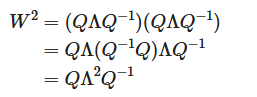

As you can see, the repeated multiplication is simply raising the eigenvalues to some power. Thus whether the repeated multiplication explodes or vanishes can largely depend on the eigenvalues.

To repeat, since the orthogononal matrix has eigenvalues of absolute value 1, thus its repeated multiplication will alleviate the vanishing/exploding gradients.

In [ ]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [ ]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)

Make sure we use the initialized embedding weight from fasttext

In [ ]:
input_dim  = len(word2idx)
hid_dim    = 256
emb_dim    = 300         #**<----change to 300
output_dim = 4 # four classes

model = paddedRNN(input_dim, emb_dim, hid_dim, output_dim).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embeddings  #**<------applied the fast text embedding as the initial weights

In [ ]:
count_params(model)

In [ ]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # combine softmax with cross entropy

In [ ]:
def train_step(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout

    for i, (label, text, text_length) in enumerate(loader):
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)

        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1

        #calculate loss
        loss = criterion(predictions, label)
        acc = accuracy(predictions, label)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [ ]:
def val_step(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader):
            label = label.to(device) #(batch_size, )
            text = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1)

            loss = criterion(predictions, label)
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

train_loader_length, val_loader_length, test_loader_length

In [ ]:
best_valid_loss = float("inf")
num_epochs      = 5

save_path = f"content/{model.__class__.__name__}.pt"

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train_step(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = val_step(model, val_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = val_step(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
# Test on some random news
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)

In [ ]:
text = text.reshape(1, -1)  # because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
text.shape

In [ ]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [ ]:
predict(text, text_length)

FastText embedding improved the accuracy by around 10 to 20%

Train 24000, Val: 12000, Test: 7600
Total Vocab: 52564
15769200
 76800
 65536
   256
   256
  1024
     4
---------
15913076
Epoch: 01 | Time: 0m 17s
	Train Loss: 0.675 | Train Acc: 73.85%
	 Val. Loss: 0.457 |  Val. Acc: 83.22%
Epoch: 02 | Time: 0m 17s
	Train Loss: 0.487 | Train Acc: 83.97%
	 Val. Loss: 0.371 |  Val. Acc: 88.29%
Epoch: 03 | Time: 0m 17s
	Train Loss: 0.676 | Train Acc: 74.65%
	 Val. Loss: 0.783 |  Val. Acc: 68.15%
Epoch: 04 | Time: 0m 17s
	Train Loss: 0.487 | Train Acc: 82.60%
	 Val. Loss: 0.800 |  Val. Acc: 64.71%
Epoch: 05 | Time: 0m 17s
	Train Loss: 0.843 | Train Acc: 68.13%
	 Val. Loss: 0.611 |  Val. Acc: 80.14%


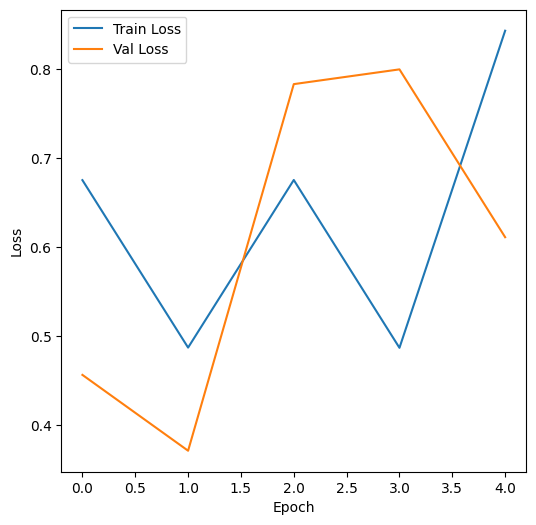

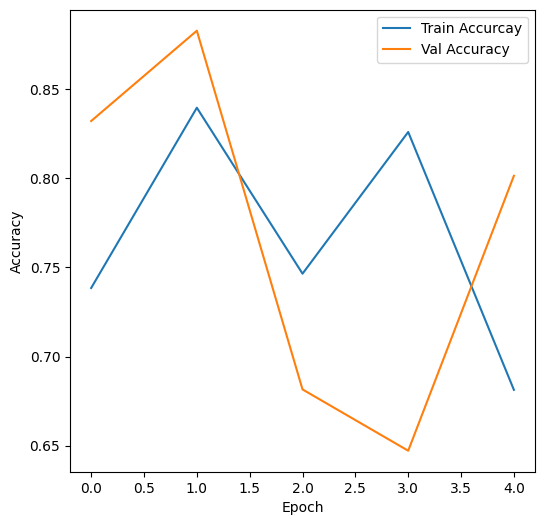


 Test Loss: 0.42698 | Test Loss: 0.86524


In [52]:
# Self
import torch, torchtext
from torch import nn as nn

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader

from torchtext.vocab import build_vocab_from_iterator, FastText

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt

import time

# Prepare Dataset
train, test = AG_NEWS()

SEED = 1234
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_length = len(list(iter(train)))
train, val, rem = train.random_split(total_length=train_length, weights={"train": 0.2, "val": 0.1, "rem": 0.7}, seed=SEED)

train_size_length = len(list(iter(train)))
val_size_length = len(list(iter(val)))
test_size_length = len(list(iter(test)))

print("Train {}, Val: {}, Test: {}".format(train_size_length, val_size_length, test_size_length))

tokenizer = get_tokenizer(tokenizer="spacy", language="en_core_web_sm")
def yield_tokens(train_data):
    for _label, _text in train:
        tokens =  tokenizer(_text)
        yield tokens

word2idx = build_vocab_from_iterator(yield_tokens(train), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
word2idx.set_default_index(word2idx["<unk>"])
idx2word = word2idx.get_itos()
vocab_size = len(word2idx)
pad_idx = word2idx["<pad>"]

print("Total Vocab: {}".format(vocab_size))

class VanillaRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)  # put padding_idx so asking the embedding layer to ignore padding
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, text_lengths):
        embeds = self.embedding(input)                                                          # (bs, seq_len) -> (bs, seq_len, embed_dim)
        packed_embeds = pack_padded_sequence(embeds, lengths=text_lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        packed_output, packed_hn = self.rnn(packed_embeds)                                      # (num_layers, bs, hidden_dim) (num_layers*num_directions, bs, hidden_dim) = (1, bs, hidden_dim)
        output, lengths = pad_packed_sequence(packed_output, batch_first=True)                  # (bs, seq_len, hidden_dim), (bs,)
        logits = self.fc(packed_hn.squeeze(dim=0))                                              # (1, bs, hidden_dim) -> (bs, hidden_dim) -> (bs, output_dim)
        # print(embeds.shape, output.shape, lengths.shape, logits.shape, packed_hn.shape)    # torch.Size([64, 138, 300]) torch.Size([64, 138, 256]) torch.Size([64]) torch.Size([64, 4]) torch.Size([1, 64, 256])
        return logits

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.orthogonal_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

def count_params(m):
    counts = [param.numel() for name, param in m.named_parameters() if param.requires_grad]
    for item in counts:
        print(f"{item:>6}")
    print(f"---------\n{sum(counts):>6}")

text_pipeline = lambda t: word2idx(tokenizer(t))
label_pipeline = lambda l: int(l)- 1

def collate_batch(batch):
    labels, texts, lengths = [], [], []
    for _label, _text in batch:
        labels.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        texts.append(processed_text)
        lengths.append(processed_text.size(0))
    return torch.tensor(labels, dtype=torch.int64), pad_sequence(texts, batch_first=True, padding_value=pad_idx), torch.tensor(lengths, dtype=torch.int64)

def accuracy(pred_logits, y_true):
    y_pred = torch.max(pred_logits.data, dim=1)[1]
    batch_accuracy = (y_pred == y_true).sum()
    accuracy = batch_accuracy / len(y_true)
    return accuracy

def elapsed_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train_step(model, train_dataloader, optimizer, criterion, train_dataloader_length):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for idx, (label, text, lengths) in enumerate(train_dataloader):
        label = label.to(device)
        text = text.to(device)
        lengths = lengths.to(device)
        optimizer.zero_grad()
        logits = model(text, lengths)
        loss = criterion(logits.squeeze(dim=1), label)
        acc = accuracy(logits, label)
        train_loss += loss.item()
        train_acc += acc.item()
        loss.backward()
        optimizer.step()
    train_epoch_loss = train_loss / train_dataloader_length
    train_epoch_acc = train_acc / train_dataloader_length
    return train_epoch_loss, train_epoch_acc

def val_step(model, val_dataloader, criterion, val_dataloader_length):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for idx, (label, text, lengths) in enumerate(val_dataloader):
            label = label.to(device)
            text = text.to(device)
            lengths = lengths.to(device)
            logits = model(text, lengths)
            loss = criterion(logits.squeeze(dim=1), label)
            acc = accuracy(logits, label)
            val_loss += loss.item()
            val_acc += acc.item()
        val_epoch_loss = val_loss / val_dataloader_length
        val_epoch_acc = val_acc / val_dataloader_length
    return val_epoch_loss, val_epoch_acc

# Training
batch_size = 64
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val, batch_size=batch_size, collate_fn=collate_batch)
test_dataloader = DataLoader(test, batch_size=batch_size, collate_fn=collate_batch)
train_loader_length = len(list(iter(train_dataloader)))
val_loader_length = len(list(iter(val_dataloader)))
test_loader_length = len(list(iter(test_dataloader)))

input_dim = len(word2idx)
embed_dim = 300
hidden_dim = 256
output_dim = 4
model = VanillaRNN(input_dim, embed_dim, hidden_dim, output_dim)
model.apply(init_weights)
model.to(device)
count_params(model)
fast_text = FastText(language="simple")
fast_vectors = fast_text.get_vecs_by_tokens(tokens=word2idx.get_itos()).to(device)
print(f"Fast Text Embeddings shape: {fast_vectors.shape}")  # vocab, emb_dim=300
model.embedding.weight.data = fast_vectors

epochs = 5
best_loss = float("inf")
save_path = f"/content/{model.__class__.__name__}.pt"
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_step(model, train_dataloader, optimizer, criterion, train_loader_length)
    val_loss, val_acc = val_step(model, val_dataloader, criterion, val_loader_length)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    elapsed_mins, elapsed_secs = elapsed_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

# Plotting
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Val Loss")
plt.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label="Train Accurcay")
ax.plot(val_accs, label="Val Accuracy")
plt.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.show()

# Test
model.load_state_dict(torch.load(save_path))
test_loss, test_acc = val_step(model, test_dataloader, criterion, test_loader_length)
print(f"\n Test Loss: {test_loss:3.5f} | Test Loss: {test_acc:3.5f}")

# Predict
def predict(text):
    with torch.no_grad():
        input = torch.tensor(text_pipeline(text)).to(device)
        input = input.reshape(1, -1)
        length = torch.tensor([input.size(1)], dtype=torch.int64)
        logits = model(input, length)
        prediction = torch.max(logits.data, dim=1)[1]
        return prediction

predict("Google is now falling nonstop.  The price is really bad now.")

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. Just like an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $X_{T-t+1}$.

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), and the last hidden state from the backward RNN (obtained from the first word of the sentence).

In implementation, the final hidden state, hidden, has a shape of

`[num layers * num directions, batch size, hid dim]`.

These are ordered: `[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]`. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer.

Also, as the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the nn.Linear layer is twice that of the hidden dimension size.

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.

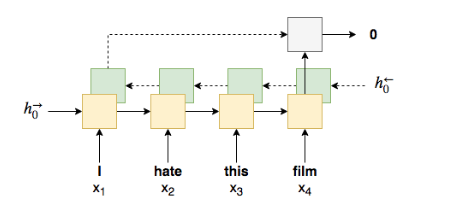

### Multi-layer RNN
Multi-layer RNNs (also called deep RNNs) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another layer. The hidden state output by the first (bottom) RNN at time-step $T$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$

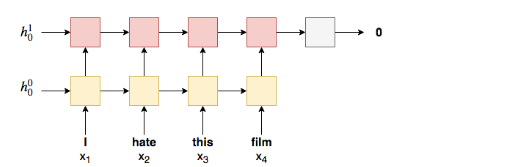